<div class="alert alert-block alert-info">
    <h1>Importing packages</h1>
</div>

In [7]:
%pylab inline
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import glob
import math
import os
import sys
import pickle
import pywt
import scipy
import xgboost as xgb
import warnings
import tensorflow as tf
from scipy.io import loadmat, savemat
from scipy import signal
from scipy import stats
from IPython.display import Image
from sklearn import datasets
from sklearn import metrics
from sklearn.model_selection import train_test_split, KFold, cross_validate, cross_val_score, GridSearchCV, RandomizedSearchCV, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler,LabelEncoder
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, make_scorer, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline, Pipeline
from numpy import linalg as LA 
from collections import Counter, defaultdict
from keras import Input
from keras.models import Sequential, model_from_json, load_model
from keras.layers import Dense, Dropout, BatchNormalization, Conv1D, Conv2D, Flatten, MaxPooling1D
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from keras.constraints import maxnorm
from keras.metrics import categorical_accuracy
from keras.optimizers import SGD, Adam
from keras.callbacks import EarlyStopping
from keras.utils.vis_utils import plot_model
#from scikeras.wrappers import KerasClassifier

Populating the interactive namespace from numpy and matplotlib


ModuleNotFoundError: No module named 'imblearn'

<div class="alert alert-block alert-info">
    <h1>Plot ROC Curves</h1>
</div>

In [2]:
# Compute ROC curve and ROC area for each class
def plot_roc_auc_curve(y_test, y_score_decision, classes, classifier):
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i, cls in enumerate(classes):
        fpr[cls], tpr[cls], _ = roc_curve(y_test[:, i], y_score_decision[:, i])
        roc_auc[cls] = auc(fpr[cls], tpr[cls])

    # Compute micro-average ROC curve and ROC area
    # ravel return a flatten array of dataframe
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score_decision.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Plot ROC curve
    plt.figure(figsize=(9,6))
    plt.plot(fpr["micro"], tpr["micro"], label=f'Micro média (área = {roc_auc["micro"]:.2f})', linewidth=4)
    
    for i in classes:
        plt.plot(fpr[i], tpr[i], label=f'Classe {i} (área = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('Curva ROC '+ classifier)
    plt.legend(loc="lower right")
    plt.savefig(os.path.abspath('./images/roc_auc_'+classifier+'.pdf'), dpi=300)
    plt.show()

In [3]:
# Compute ROC curves for all classifiers
def plot_all_roc_auc_curves(y_test, y_score_decision, classifiers):
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    # Compute micro-average ROC curve and ROC area
    # ravel return a flatten array of dataframe    
    for decision, classifiers_ in zip(y_score_decision,classifiers):
        fpr[classifiers_], tpr[classifiers_], _ = roc_curve(y_test.ravel(), decision.ravel())
        roc_auc[classifiers_] = auc(fpr[classifiers_], tpr[classifiers_])

    # Plot ROC curve
    plt.figure(figsize=(12,8))
    
    for classifiers_ in classifiers:
        plt.plot(fpr[classifiers_], tpr[classifiers_], label=f'{classifiers_} (área = {roc_auc[classifiers_]:.2f})', linewidth=4)

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.title('Comparativos de Curvas ROC')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.legend(loc="lower right")
    plt.savefig(os.path.abspath('./images/roc_auc_all.pdf'), dpi=300)
    plt.show()

<div class="alert alert-block alert-info">
    <h1>Reading files</h1>
</div>

In [4]:
#path general and files of signals
path_denoised = './dataset/MIT_denoised_without_normalization/'
path = './dataset/MIT/'
files_train = ['101.mat','106.mat','108.mat','109.mat','112.mat','114.mat','115.mat',
              '116.mat','118.mat','119.mat','122.mat','124.mat','201.mat','203.mat',
              '205.mat','207.mat','208.mat','209.mat','215.mat','220.mat','223.mat','230.mat']
files_test = ['100.mat','103.mat','105.mat','111.mat','113.mat','117.mat','121.mat',
              '123.mat','200.mat','202.mat','210.mat','212.mat','213.mat','214.mat',
              '219.mat','221.mat','222.mat','228.mat','231.mat','232.mat','233.mat','234.mat']

<div class="alert alert-block alert-info">
    <h1>Segmentation</h1>
</div>

In [24]:
def load_signals(path, path_denoised, list_ecgs, size_beat):
    dict_signals = defaultdict(list) #dict to load beats
    
    for file in list_ecgs:               
     
        struct = loadmat(path + file) #loading the original file
        data = struct['individual'][0][0] #loading info of the signal
        #ecg = data['signal_r'][:, 1] #reading lead II
        beat_peaks = data['anno_anns'] #reading R-peak
        beat_types = data['anno_type'] #reading type of beat
        
        struct_denoised = loadmat(path_denoised+file) #loading the denoised file
        ecg = struct_denoised['data'][0] #loading info of the signal

        for peak, beat_type in zip(beat_peaks, beat_types):
            
            beat_samples=[] #list to save samples of beat
            
            half_beat = int(size_beat/2) #half of size beat

            #if the position is before the begining or 
            #if the position is after the ending
            #do nothing
            if (peak - half_beat) < 0 or (peak + half_beat) > len(ecg):
                continue
            
            #if type of beat is different than this list, do nothing
            if beat_type not in 'NLRejAaJSVEFP/fUQ':
                continue

            #taking the samples of beat window
            beat_samples = ecg[int(peak - half_beat):int(peak + half_beat)]
            
            #taking the type of beat and saving in dict
            if beat_type in 'NLRej':
                dict_signals['N'].append(beat_samples)
            elif beat_type in 'AaJS':
                dict_signals['S'].append(beat_samples)
            elif beat_type in 'VE':
                dict_signals['V'].append(beat_samples)
            elif beat_type in 'F':
                dict_signals['F'].append(beat_samples)
            else:
                dict_signals['Q'].append(beat_samples) 
                
    return dict_signals

In [27]:
#segmentation of train and test files using DWT without normalization
dict_signals_train = load_signals(path,path_denoised,files_train,300)
dict_signals_test =load_signals(path,path_denoised,files_test,300)

In [29]:
#signals without normalization
sum_beats = len(dict_signals_train['N'])+len(dict_signals_train['S'])+len(dict_signals_train['V'])+len(dict_signals_train['F'])+len(dict_signals_train['Q'])+len(dict_signals_test['N'])+len(dict_signals_test['S'])+len(dict_signals_test['V'])+len(dict_signals_test['F'])+len(dict_signals_test['Q'])

print(f"Number of class N: TRAIN -> {len(dict_signals_train['N'])},\t TEST -> {len(dict_signals_test['N'])},\t TOTAL -> {len(dict_signals_train['N'])+len(dict_signals_test['N'])} ({((len(dict_signals_train['N'])+len(dict_signals_test['N']))/sum_beats)*100:.2f}%)")
print(f"Number of class S: TRAIN -> {len(dict_signals_train['S'])},\t TEST -> {len(dict_signals_test['S'])},\t TOTAL -> {len(dict_signals_train['S'])+len(dict_signals_test['S'])} ({((len(dict_signals_train['S'])+len(dict_signals_test['S']))/sum_beats)*100:.2f}%)")
print(f"Number of class V: TRAIN -> {len(dict_signals_train['V'])},\t TEST -> {len(dict_signals_test['V'])},\t TOTAL -> {len(dict_signals_train['V'])+len(dict_signals_test['V'])} ({((len(dict_signals_train['V'])+len(dict_signals_test['V']))/sum_beats)*100:.2f}%)")
print(f"Number of class F: TRAIN -> {len(dict_signals_train['F'])},\t TEST -> {len(dict_signals_test['F'])},\t TOTAL -> {len(dict_signals_train['F'])+len(dict_signals_test['F'])} ({((len(dict_signals_train['F'])+len(dict_signals_test['F']))/sum_beats)*100:.2f}%)")
print(f"Number of class Q: TRAIN -> {len(dict_signals_train['Q'])},\t\t TEST -> {len(dict_signals_test['Q'])},\t TOTAL -> {len(dict_signals_train['Q'])+len(dict_signals_test['Q'])} ({((len(dict_signals_train['Q'])+len(dict_signals_test['Q']))/sum_beats)*100:.2f}%)")
print('\n')
print(f'TOTAL OF BEATS: {sum_beats}')

Number of class N: TRAIN -> 45844,	 TEST -> 44238,	 TOTAL -> 90082 (89.47%)
Number of class S: TRAIN -> 944,	 TEST -> 1837,	 TOTAL -> 2781 (2.76%)
Number of class V: TRAIN -> 3788,	 TEST -> 3220,	 TOTAL -> 7008 (6.96%)
Number of class F: TRAIN -> 414,	 TEST -> 388,	 TOTAL -> 802 (0.80%)
Number of class Q: TRAIN -> 8,		 TEST -> 7,	 TOTAL -> 15 (0.01%)


TOTAL OF BEATS: 100688


In [44]:
#---training------
list_labels = [] #list to append type beats
list_beats = [] #list to append values beats
label_type = 'type_beat'

for class_, signal_ in dict_signals_train.items():
    for beat in signal_:
        list_labels.append(class_)
        list_beats.append(beat)
        
df_train = pd.DataFrame(list_beats) #creating the dataframe
df_train.loc[:,label_type] = list_labels #append the type beats 

#---test------
list_labels = [] #list to append type beats
list_beats = [] #list to append values beats

for class_, signal_ in dict_signals_test.items():
    for beat in signal_:
        list_labels.append(class_)
        list_beats.append(beat)
        
df_test = pd.DataFrame(list_beats) #creating the dataframe
df_test.loc[:,label_type] = list_labels #append the type beats 

In [45]:
df_train.shape

(50998, 301)

In [46]:
df_test.shape

(49690, 301)

In [113]:
X_train,y_train = df_train.drop(['type_beat'], axis=1), df_train[['type_beat']]
X_test,y_test = df_test.drop(['type_beat'], axis=1), df_test[['type_beat']]

In [114]:
X = X_train.values.astype(float)
y = y_train.values.squeeze()

X_t = X_test.values.astype(float)
y_t = y_test.values.squeeze()

In [122]:
X.shape

(50998, 300)

In [123]:
X_t.shape

(49690, 300)

In [144]:
#(number_samples, length_samples,channel_sample)
X_reshape = X.reshape(50998,300,1)
X_t_reshape = X_t.reshape(49690,300,1)

In [155]:
X_reshape.shape[1:3]

(300, 1)

In [124]:
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(y)
encoded_y = encoder.transform(y)
dummy_y = np_utils.to_categorical(encoded_y)

# encode class values as integers
encoder = LabelEncoder()
encoder.fit(y_t)
encoded_y_test = encoder.transform(y_t)
dummy_y_test = np_utils.to_categorical(encoded_y_test)

<div class="alert alert-block alert-info">
    <h1>Convolutional Neural Network</h1>
</div>

In [160]:
def create_model(X):
    model = Sequential()
    model.add(Conv1D(X.shape[0],1, input_shape=X.shape[1:3]))
    model.add(Conv1D(334,kernel_size=27, activation='relu',strides=1))
    model.add(MaxPooling1D(167, strides=2))
    model.add(Conv1D(154, kernel_size=14, activation='relu', strides=1))
    model.add(MaxPooling1D(77, strides=2))
    model.add(Conv1D(75, kernel_size=3, activation='relu', strides=1))   
    model.add(MaxPooling1D(37, strides=2))
    model.add(Conv1D(34, kernel_size=1, activation='relu', strides=1))    
    model.add(MaxPooling1D(17, strides=2))
    model.add(Flatten())
    model.add(Dense(148, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(3, activation='softmax'))
              
    model.summary()
    adam = Adam(learning_rate=1e-3)
    model.compile(loss='categorical_crossentropy', 
                  optimizer=adam, 
                  metrics=['accuracy'])
    
    return model

In [161]:
#stop training when loss has stopped improving after 10 epochs
es = EarlyStopping(monitor='loss', 
                   mode='min',
                   patience=10, 
                   restore_best_weights=True)

In [ ]:
model = create_model(X_reshape)

In [ ]:
history = model.fit(X, 
                    dummy_y, 
                    epochs=30, 
                    batch_size=34, 
                    shuffle=True,
                    validation_data=(X_t, dummy_y_test),
                    verbose=1)

In [168]:
scv =  StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
scores_ = {'accuracy' : metrics.make_scorer(metrics.accuracy_score),
           'recall'   : metrics.make_scorer(metrics.recall_score, average='weighted', zero_division=0),
           'precision': metrics.make_scorer(metrics.precision_score, average='weighted', zero_division=0),
           'f1'       : metrics.make_scorer(metrics.fbeta_score, beta = 2, average='weighted' )}

svm_result = cross_validate(svm_scaler, 
                            data, 
                            target, 
                            scoring=scores_, 
                            cv=scv, 
                            n_jobs=-1,
                            return_train_score=True)

<div class="alert alert-block alert-info">
    <h1>Neural Network</h1>
</div>

In [4]:
#using beats with dwt sym9 function denoise
df_train = pd.read_csv(os.path.abspath('./dataset/MIT_feat_extracted/non_normalization/df_beats_train_dwt_db14.csv'),header=0, index_col=[0])
df_test = pd.read_csv(os.path.abspath('./dataset/MIT_feat_extracted/non_normalization/df_beats_test_dwt_db14.csv'),header=0, index_col=[0])

In [5]:
#removing classes F and Q
df_train = df_train.query('type_beat != ["F","Q"]')
df_test = df_test.query('type_beat != ["F","Q"]')

In [6]:
#splitting the train dataset
X_train,y_train = df_train.drop(['type_beat'],axis=1), df_train[['type_beat']]

In [7]:
#splitting the test dataset
X_test,y_test = df_test.drop(['type_beat'],axis=1), df_test[['type_beat']]

In [8]:
#counting the classes 
Counter(df_train['type_beat'])

Counter({'N': 45844, 'S': 944, 'V': 3788})

In [9]:
#counting the classes 
Counter(df_test['type_beat'])

Counter({'N': 44238, 'S': 1837, 'V': 3220})

In [10]:
#applying SMOTE in training set of dwt denoise

sm = SMOTE()
X_train_smote, y_train_smote = sm.fit_resample(X_train,y_train)

In [11]:
Counter(y_train_smote['type_beat'])

Counter({'N': 45844, 'S': 45844, 'V': 45844})

In [12]:
#reshape the dataframes of data and target
X = X_train_smote.values.astype(float)
y = y_train_smote.values.squeeze()

In [13]:
#reshape the dataframes of data and target
X_t = X_test.values.astype(float)
y_t = y_test.values.squeeze()

In [14]:
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(y)
encoded_y = encoder.transform(y)
dummy_y = np_utils.to_categorical(encoded_y)

In [15]:
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(y_t)
encoded_y_t = encoder.transform(y_t)
dummy_y_t = np_utils.to_categorical(encoded_y_t)

In [16]:
X.shape

(137532, 56)

In [17]:
# define baseline model
def model_1(X):
    
    model = Sequential()
    model.add(Dense(10, input_shape=(X.shape[1],), activation='relu'))
    model.add(Dense(3, activation='softmax'))
    model.summary()
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [18]:
#stop training when loss has stopped improving after 10 epochs
es = EarlyStopping(monitor='loss', 
                   mode='min',
                   patience=10, 
                   restore_best_weights=True)

In [19]:
model = model_1(X)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                570       
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 33        
Total params: 603
Trainable params: 603
Non-trainable params: 0
_________________________________________________________________


In [20]:
history = model.fit(X, 
                    dummy_y, 
                    epochs=8000000, 
                    callbacks=[es], 
                    batch_size=10, 
                    shuffle=True,
                    validation_split=0.2,
                    verbose=1)

Epoch 1/8000000


InternalError:  Blas GEMM launch failed : a.shape=(10, 56), b.shape=(56, 10), m=10, n=10, k=56
	 [[node sequential/dense/MatMul (defined at <ipython-input-20-77b2d2939b7d>:1) ]] [Op:__inference_train_function_580]

Function call stack:
train_function


In [ ]:
loss, accuracy = model.evaluate(X, dummy_y)
print(f'Accuracy: {(accuracy*100):.2f} ({loss:.2f})')

<div class="alert alert-block alert-info">
    <h1>Gradient Boosting</h1>
</div>

In [36]:
dec_funct_grd = grd.decision_function(X_test)

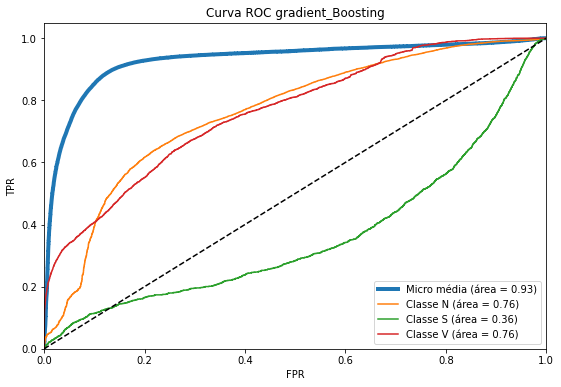

In [39]:
plot_roc_auc_curve(dummy_test_y, dec_funct_grd, list(grd.classes_), 'gradient_Boosting')